In [1]:
from netCDF4 import Dataset as open_ncfile
import matplotlib.pyplot as plt
import numpy as np
import pandas

/home/jcharrel/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
# OBS
# ----------------------------------------------------------------------------

foceobs = pandas.read_csv('land_ocean_mask2_2d_v2.asc',sep=';')
foceobs = foceobs.values
foceobs[foceobs == 0.] = np.nan
foceobs[foceobs == 1.] = 1.

nc = open_ncfile('cllcalipso_obs4cmip5_CALIOP_L3_CALIPSO-GOCCP-v2.1_2007-2008.nc', 'r')
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time'][:]
cc = nc.variables['cllcalipso'][:]
cc[cc < 1E-2] = np.nan
cc[cc > 1.] = np.nan

# Shiftgrid
longi_shift = lon + 180.0
longi_shift[longi_shift > 360] -= 360

ccobs = np.zeros(cc.shape)
for i in range(len(lon)):
    idx = np.where(longi_shift[i] == lon)[0][0]
    ccobs[:,:, i] = cc[:, :, idx]

ccobsf = ccobs[0,:,:]*foceobs
for itime in range(1,ccobs.shape[0]):
    cctmp = ccobs[itime,:,:]*foceobs
    ccobsf = np.dstack((cctmp,ccobsf))
    #print(ccobsf.shape)

ccobsf = np.stack(np.stack(ccobsf, axis=2),axis=2)

In [11]:
ccobsflat=np.ndarray.flatten(ccobsf[:,30:60,:])
#ccobsflat=np.ndarray.flatten(ccobsf[:,:15,:]) #sous 60°S
#ccobsflat=np.ndarray.flatten(ccobsf[:,:30,:]) #sous 30°S
ccobsflat=ccobsflat[~np.isnan(ccobsflat)]

In [4]:
nc = open_ncfile('LmdzOr6Actrl_SE_1980_1999_1M_histmth_fract_oce.nc')
# Ici je fais un floor car je ne veux que les points purement oceans
foce = np.nanmean(nc.variables['fract_oce'][:],axis=0)
foce[foce == 1] = np.nan
ntgcm=3600

In [5]:
# LMDZ6A
# ----------------------------------------------------------------------------

nc = open_ncfile('LmdzOr6Actrl_19900101_19991230_1D_cllcalipso.nc')
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time_counter'][:]
cc = nc.variables['cllcalipso'][:]
cc[cc > 1.] = np.nan
cc[cc < 1E-2] = np.nan

cc6A = cc[0,:,:]*foce
for itime in range(1,ntgcm):
#for itime in range(1,cc.shape[0]):
    cctmp = cc[itime,:,:]*foce
    cc6A = np.dstack((cctmp,cc6A))
    #print(cc6A.shape)

cc6A = np.stack(np.stack(cc6A, axis=2),axis=2)

In [12]:
cc6Aflat=np.ndarray.flatten(cc6A[:,48:95,:])
#cc6Aflat=np.ndarray.flatten(cc6A[:,120:,:]) # sous 60°S
#cc6Aflat=np.ndarray.flatten(cc6A[:,96:,:]) # sous 30°S
cc6Aflat=cc6Aflat[~np.isnan(cc6Aflat)]

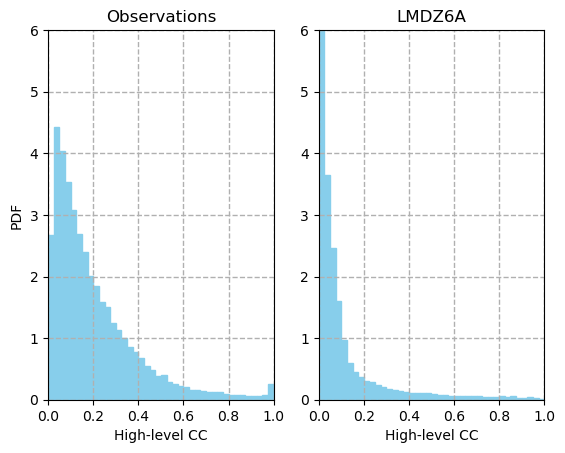

In [13]:
fig, ax = plt.subplots(1,2)

ax[0].hist(ccobsflat, range = (0, 1), bins = 40, color = 'skyblue',
            edgecolor = 'skyblue', density=True)
ax[0].grid(linestyle='--', linewidth=1)

ax[1].hist(cc6Aflat, range = (0, 1), bins = 40, color = 'skyblue',
            edgecolor = 'skyblue', density=True)
ax[1].grid(linestyle='--', linewidth=1)

ax[0].set_ylabel('PDF')
ax[0].set_title('Observations')
ax[1].set_title('LMDZ6A')
for ax in ax.flat:
    ax.set_xlabel(r"High-level CC")
    ax.set_xlim(xmin=0,xmax=1)
    ax.set_ylim(ymin=0,ymax=6)
    ax.set_xticks(np.arange(0, 101, 20)/1E2)

path_fig = '/home/jcharrel/Documents/stage_M2/figures/histograms/'
plt.savefig(path_fig+'histo_cll_obs_lmdz6a_tropical_continent.png',dpi=300)